In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 

class ConvNetwork(nn.Module):
    # original shape of images [bz, 3, 28, 28]
    # input_layer: 3 input channels, 6 output channels, 5 kernel size 
    def __init__(self):
        super(ConvNetwork, self).__init__() 
        self.conv1 = nn.Conv2d(1, 6, 5) # [bz, 3, 28, 28] -> [bz, 6, 24, 24]
        self.pool = nn.MaxPool2d(2, 2)  # [bz, 6, 24, 24] -> [bz, 6, 12, 12]
        self.conv2 = nn.Conv2d(6, 16, 3)# [bz, 6, 12, 12] -> [bz, 16, 10, 10] 
        # pool: [bz, 16, 10, 10] -> [bz, 16, 5, 5]
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # [bz, 16, 5, 5] -> [bz, 120]
        self.fc2 = nn.Linear(120, 84) # [bz, 120] -> [bz, 84]
        self.fc3 = nn.Linear(84, 10) # [bz, 84] -> [bz, 10]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # flatten the output of conv2 to (batch_size, 16*5*5)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    



torch.Size([200, 1, 28, 28]) torch.Size([200])


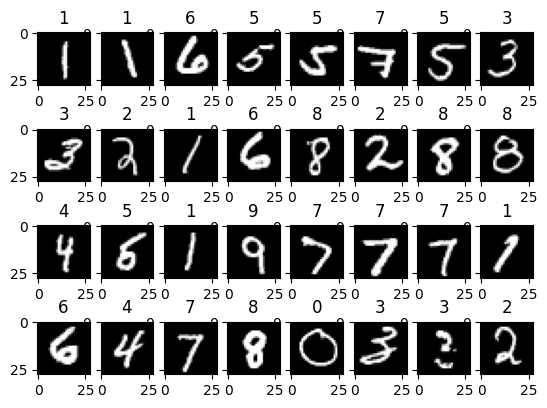

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms 
import torchvision.datasets as datasets
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, Dataset 
import sys

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/mnist")

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters 
input_size = 784 # 28x28
hidden_size = 50
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 0.001

# MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, ), (0.5, ))]
)
 
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True) 
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) 

examples = iter(train_loader) 
images, labels = examples.__next__()
print(images.shape, labels.shape) 

for i in range(32):
    plt.subplot(4, 8, i+1) 
    plt.imshow(images[i][0], cmap='gray')
    plt.title(labels[i].item())
plt.show()

# img_grid = torchvision.utils.make_grid(images)
# writer.add_image('mnist_images', img_grid)

In [10]:
model = ConvNetwork()
# loss and optimizer 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

# training loop 
n_total_steps = len(train_loader)
running_loss = 0.0 
running_correct = 0 
running_loss_list = []
running_correct_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)

        # forward pass 
        outputs = model(images) 
        loss = criterion(outputs, labels) 
        # backward pass and update weights 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # tensorbard 
        running_loss += loss.item() 
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss = {running_loss/100:.3f}')
            writer.add_scalar('training loss', running_loss/100, epoch*n_total_steps + 1)
            writer.add_scalar('accuracy', running_correct/100, epoch*n_total_steps + 1)         
            running_loss_list.append(running_loss/100)
            running_correct_list.append(running_correct/100)
            running_loss = 0.0
            running_correct = 0
# Test 
preds = [] 
pred_labels = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device) 
        labels = labels.to(device) 
        outputs = model(images) 

        # max returns (value, index) 
        _, predicted = torch.max(outputs.data, 1) 
        n_samples += labels.shape[0] 
        n_correct += (predicted == labels).sum().item() 

        # classification results for tensorboard 
        class_predictions = [F.softmax(output, dim=0) for output in outputs]
        # print(predicted, labels)
        preds.append(class_predictions) 
        pred_labels.append(predicted) 

    preds = torch.cat([torch.stack(batch) for batch in preds])
    pred_labels = torch.cat(pred_labels, dim=0) 
    acc = 100.0 * n_correct / n_samples 
    print(f'Accuracy on the testing images = {acc}%')

    for i in range(num_classes):
        labels_i = pred_labels == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()

epoch 1/20, step 100/300, loss = 2.307
epoch 1/20, step 200/300, loss = 2.306
epoch 1/20, step 300/300, loss = 2.305
epoch 2/20, step 100/300, loss = 2.305
epoch 2/20, step 200/300, loss = 2.304
epoch 2/20, step 300/300, loss = 2.303
epoch 3/20, step 100/300, loss = 2.302
epoch 3/20, step 200/300, loss = 2.302
epoch 3/20, step 300/300, loss = 2.301
epoch 4/20, step 100/300, loss = 2.300
epoch 4/20, step 200/300, loss = 2.300
epoch 4/20, step 300/300, loss = 2.298
epoch 5/20, step 100/300, loss = 2.298
epoch 5/20, step 200/300, loss = 2.297
epoch 5/20, step 300/300, loss = 2.297
epoch 6/20, step 100/300, loss = 2.296
epoch 6/20, step 200/300, loss = 2.295
epoch 6/20, step 300/300, loss = 2.295
epoch 7/20, step 100/300, loss = 2.294
epoch 7/20, step 200/300, loss = 2.293
epoch 7/20, step 300/300, loss = 2.293
epoch 8/20, step 100/300, loss = 2.292
epoch 8/20, step 200/300, loss = 2.292
epoch 8/20, step 300/300, loss = 2.291
epoch 9/20, step 100/300, loss = 2.290
epoch 9/20, step 200/300,

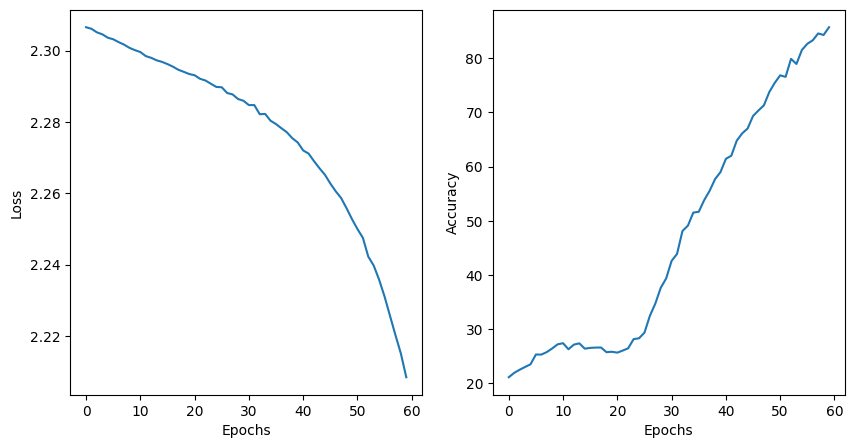

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
axs[0].plot(running_loss_list, label='training loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].plot(running_correct_list, label='training accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.show()

## Pytorch Lightning Implementation

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl 
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset 

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))]
)

# Hyperparameters 

num_epochs = 5 
batch_size = 100 
learning_rate = 0.001

class LitCNN(pl.LightningModule):
    # original shape of images [bz, 3, 28, 28]
    # input_layer: 3 input channels, 6 output channels, 5 kernel size 
    def __init__(self):
        super(LitCNN, self).__init__() 
        self.conv1 = nn.Conv2d(1, 6, 5) # [bz, 3, 28, 28] -> [bz, 6, 24, 24]
        self.pool = nn.MaxPool2d(2, 2)  # [bz, 6, 24, 24] -> [bz, 6, 12, 12]
        self.conv2 = nn.Conv2d(6, 16, 3)# [bz, 6, 12, 12] -> [bz, 16, 10, 10] 
        # pool: [bz, 16, 10, 10] -> [bz, 16, 5, 5]
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # [bz, 16, 5, 5] -> [bz, 120]
        self.fc2 = nn.Linear(120, 84) # [bz, 120] -> [bz, 84]
        self.fc3 = nn.Linear(84, 10) # [bz, 84] -> [bz, 10]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # flatten the output of conv2 to (batch_size, 16*5*5)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=learning_rate)
    
    def training_step(self, batch, batch_idx):
        images, labels = batch  

        outputs = self(images) 
        loss = F.cross_entropy(outputs, labels)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def train_dataloader(self):
        train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        return train_loader


model = LitCNN() 
trainer = pl.Trainer(max_epochs=num_epochs, fast_dev_run=False) 
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: d:\Desktop\AI-ML-methods\homework\assignment6\lightning_logs


Epoch 0:   0%|          | 0/1 [02:07<?, ?it/s]



  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 156   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 880   
3 | fc1   | Linear    | 48.1 K
4 | fc2   | Linear    | 10.2 K
5 | fc3   | Linear    | 850   
------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Total params
0.241     Total estimated model params size (MB)
d:\Code\Anaconda\envs\ml\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 600/600 [00:16<00:00, 37.18it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 600/600 [00:16<00:00, 37.17it/s, v_num=0]
